<a href="https://colab.research.google.com/github/unclebob7/Adabot/blob/master/test_on_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGM on MNIST

In [1]:
!pip install torch torchvision

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
from view_bar import view_bar

In [0]:
BATCH_SIZE = 16
NUM_EPOCHS = 1700

## Data preprocessing

In [0]:
# preprocessing
standardize = transforms.Normalize(mean=[0.5], std=[0.5])
transform_ins = transforms.Compose([transforms.ToTensor, standardize])

# load mnist
train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_ins)
test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_ins)

# random seed
np.random.seed(7)

# training set
train_src = np.array(train.data)
train_target = np.array(train.targets)  
                         
# test set
test_src = np.array(test.data)
test_target = np.array(test.targets)

## Data Exploration

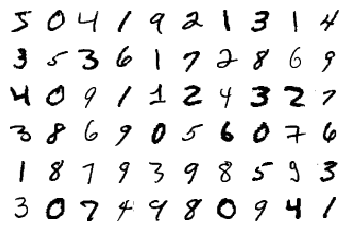

In [5]:
num_img = 60
for i in range(num_img):
    plt.subplot(6, 10, i+1)
    plt.axis("off")
    plt.imshow(np.array(train_src[i]).squeeze(), cmap="gray_r")

## Model construction

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 64)
        self.l5 = nn.Linear(64, 64)
        self.l6 = nn.Linear(64, 64)
        self.l7 = nn.Linear(64, 64)
        self.l8 = nn.Linear(64, 64)
        self.l9 = nn.Linear(64, 64)
        self.l10 = nn.Linear(64, 64)
        self.l11 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data
        latent1 = F.relu(self.l1(x))
        latent2 = F.relu(self.l2(latent1))
        latent3 = F.relu(self.l3(latent2))
        latent4 = F.relu(self.l4(latent3))
        latent5 = F.relu(self.l5(latent4))
        latent6 = F.relu(self.l6(latent5))
        latent7 = F.relu(self.l7(latent6))
        latent8 = F.relu(self.l8(latent7))
        latent9 = F.relu(self.l9(latent8))
        latent10 = F.relu(self.l10(latent9))
        output = F.softmax(self.l11(latent10), dim=1)
        return latent1, latent2, latent3, latent4, latent5, latent6, latent7, latent8, latent9, latent10, output
    
    def hardwire(self, hw_vector):
        """
        hw_vector represents the post inversed PCA vector for hardwiring
        hw_result is the hardwired inference
        """
        hw_result = F.relu(self.l11(hw_vector))
        return hw_result

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
print(model)

Net(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=64, bias=True)
  (l5): Linear(in_features=64, out_features=64, bias=True)
  (l6): Linear(in_features=64, out_features=64, bias=True)
  (l7): Linear(in_features=64, out_features=64, bias=True)
  (l8): Linear(in_features=64, out_features=64, bias=True)
  (l9): Linear(in_features=64, out_features=64, bias=True)
  (l10): Linear(in_features=64, out_features=64, bias=True)
  (l11): Linear(in_features=64, out_features=10, bias=True)
)


## Optimization

In [0]:
# loss_fn and optimizer nodes
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
def print_(loss):
    print("loss: {0}".format(loss))
    
def acc_print(target, pred):
    score = accuracy_score(target, np.argmax(pred.detach().numpy(), axis=1))
    print("accuracy: {0}".format(score))

## Training

In [15]:
x_train, y_train = Variable(torch.from_numpy(train_src)).float(), Variable(torch.from_numpy(train_target)).long()
for epoch in range(1, NUM_EPOCHS + 1):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    *_, y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    y_pred_a = y_pred.detach().cpu().numpy()
    accur = accuracy_score(y_train.detach().cpu().numpy(), np.argmax(y_pred_a, axis=1))
    view_bar("training sequence: " ,epoch, NUM_EPOCHS, accur)
    
    # back propagation
    optimizer.zero_grad()
    loss.backward() # Gradients
    optimizer.step() # Update

training sequence: :[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100%	1700/1700	98.44%

**Save checkpoint**

In [0]:
PATH = './mnist_ckpt.pth'
torch.save(model.state_dict(), PATH)

## Testing